# Test of particle pusher (Boris method) in electromagnetic field
The Boris method for particle positions and velocities reads as follows:

\begin{align}
q^\prime=\Delta t\frac{q}{2m} \\
\textbf{h} = q^\prime\textbf{B}(\textbf{x}^n) \\
\textbf{s}=2\textbf{h}/(1+h^2) \\
\textbf{u}=\textbf{v}^{n-1/2}+q^\prime\textbf{E}(\textbf{x}^n) \\
\textbf{u}^\prime=\textbf{u}+(\textbf{u}+(\textbf{u}\times\textbf{h}))\times\textbf{s} \\
\textbf{v}^{n+1/2}=\textbf{u}^\prime+q^\prime\textbf{E}(\textbf{x}^n) \\ 
\textbf{x}^{n+1}=\textbf{x}^n+\Delta t\textbf{v}^{n+1/2} 
\end{align}

As an example the method is applied to some particles in a constant magnetic field $\textbf{B}_0=B_{0z}\textbf{e}_z$ and electric field $\textbf{E}_0=E_{0x}\textbf{e}_x+E_{0y}\textbf{e}_y$.

This leads to an $\textbf{E}\times\textbf{B}$-drift.

Text(0.5,0.92,'Verification of particle mover')

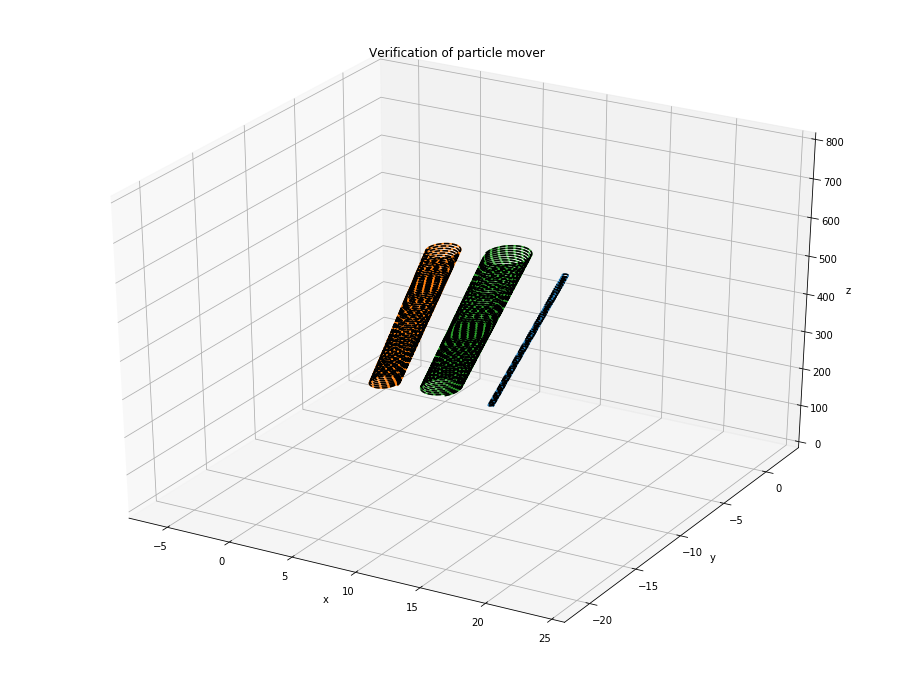

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from copy import deepcopy



# ... parameters
q = -1                          # ... charge of particle
m = 1                           # ... mass of particle
dt = 0.05                       # ... time step
Nt = 8000                       # ... number of time steps
T = dt*Nt                       # ... simulation time
dt = T/Nt                       # ... time step
Omega = q*B0z/m                 # ... cyclotron frequency
B0 = np.array([0,0,1.0])        # ... constant background magnetic field (for ExB-drift)
E0 = np.array([0.05,0.05,0])    # ... constant background electric field (for ExB-drift)
Np = 3                          # ... number of particles
Lz = 600                        # ... length of z-domain

B0z = 1.0                       # ... field at x = 0 for magnetic mirror
xi = 0.862                      # ... inhomogeneity factor of magnetic mirror
# ...




# ... define magnetic mirror
def Bfield3d3v(x,B0z,xi):
    
    Bx = -x[:,0]*B0z*xi*x[:,2]
    By = -x[:,1]*B0z*xi*x[:,2]
    Bz = B0z*(1 + xi*x[:,2]**2)
    
    return np.transpose(np.array([Bx,By,Bz]))



def Bfield1d3v(z,v,B0z,xi):
    
    Bz = B0z*(1 + xi*z**2)
    Omega = q*Bz/m
    rho = -np.cross(v,np.array([0,0,1]))/Omega[:,None]
    
    
    Bx = -rho[:,0]*B0z*xi*z
    By = -rho[:,1]*B0z*xi*z
    
    
    return np.transpose(np.array([Bx,By,Bz]))
# ...





# ... create test particles
tn = np.linspace(0,T,Nt+1)

particlesExB = np.zeros((Nt+1,3,6))
particles3d3v = np.zeros((Nt+1,2,6))
particles1d3v = np.zeros((Nt+1,2,4))
# ... 


# ... set initial values for ExB-particles
particlesExB[0,0,3:6] = np.array([0.,0.14,2.]) 
particlesExB[0,1,3:6] = np.array([0.,1.,2.]) 
particlesExB[0,2,3:6] = np.array([1.,1.,2.]) 

rl1 = np.abs(m*particlesExB[0,0,4]/(q*np.linalg.norm(B0)))
rl2 = np.abs(m*particlesExB[0,1,4]/(q*np.linalg.norm(B0)))

particlesExB[0,0,0] = 4.
particlesExB[0,1,0] = -4.
particlesExB[0,2,0] = 0.
# ...



# ... set initial values for magnetic mirror particles
particles3d3v[0,0,3:6] = np.array([0.117,0,0.0795])
particles3d3v[0,1,3:6] = np.array([0.167,0,0.0595])

particles3d3v[0,0,0:3] = np.array([0,np.abs(particles3d3v[0,0,3]*m/(q*B0[2])),0])
particles3d3v[0,1,0:3] = np.array([0,np.abs(particles3d3v[0,1,3]*m/(q*B0[2])),0])

particles1d3v[0,0,1:4] = np.array([0.117,0,0.0795])
particles1d3v[0,1,1:4] = np.array([0.167,0,0.0595])

particles1d3v[0,0,0] = 0.0
particles1d3v[0,1,0] = -1.6
# ...




# ... analytical solution for ExB-drift
v0 = deepcopy(particlesExB[0,:,3:6])
x0 = deepcopy(particlesExB[0,:,0:3])

def analytical(x0,v0,t):
    
    x = x0[0] + 1/Omega*(E0[0]/B0z + v0[1])*(1 - np.cos(Omega*t)) + 1/Omega*(v0[0] - E0[1]/B0z)*np.sin(Omega*t) + E0[1]/B0z*t
    y = x0[1] + 1/Omega*(E0[1]/B0z - v0[0])*(1 - np.cos(Omega*t)) + 1/Omega*(v0[1] + E0[0]/B0z)*np.sin(Omega*t) - E0[0]/B0z*t    
    z = x0[2] + v0[2]*t
    
    return np.array([x,y,z])
# ...
    

# ... fields at particle positions    
BpExB = np.zeros((3,3))
EpExB = np.zeros((3,3))

Bpmirror = np.zeros((2,3))
Epmirror = np.zeros((2,3))
# ...


# ... analytical solution for magnetic mirror
z0mirror = deepcopy(particles1d3v[0,0,0])
v0mirror = deepcopy(particles1d3v[0,0,1:4])


def zana1(t):
    
    Bz = B0z*(1 + xi*z0mirror**2)
    Omega = q*Bz/m
    rho = -np.cross(v0mirror,np.array([0,0,1]))/Omega
    
    omegab = v0mirror[0]*np.sqrt(xi/np.sqrt((1 + xi*z0mirror**2)**2 + (rho[0]*B0z*xi*z0mirror)**2 + (rho[1]*B0z*xi*z0mirror)**2))
    
    return z0mirror*np.cos(omegab*t) + v0mirror[2]/omegab*np.sin(omegab*t)


# ...



# ... define Boris method
def pushBoris3d3v(particles,q,m,dt,B,E):
    
    qprime = dt*q/(2*m)
    h = qprime*B
    s = 2*h/(1 + np.linalg.norm(h,axis = 1)**2)[:,None]
    u = particles[:,3:6] + qprime*E
    uprime = u + np.cross(u + np.cross(u,h),s)
    vnew = uprime + qprime*E
    xnew = particles[:,0:3] + dt*vnew 
       
    return xnew,vnew


def pushBoris1d3v(particles,q,m,dt,B,E):
    
    qprime = dt*q/(2*m)
    h = qprime*B
    s = 2*h/(1 + np.linalg.norm(h,axis = 1)**2)[:,None]
    u = particles[:,1:4] + qprime*E
    uprime = u + np.cross(u + np.cross(u,h),s)
    vnew = uprime + qprime*E
    znew = particles[:,0] + dt*vnew[:,2] 
       
    return znew,vnew
# ...



# ... initialize velocities by pushing velocities back by -dt/2
particlesExB[0,:,3:6] = pushBoris3d3v(particlesExB[0],q,m,-dt/2,B0 + BpExB,E0 + EpExB)[1]
particles3d3v[0,:,3:6] = pushBoris3d3v(particles3d3v[0],q,m,-dt/2,Bfield3d3v(particles3d3v[0,:,0:3],B0z,xi),Epmirror)[1]
particles1d3v[0,:,1:4] = pushBoris1d3v(particles1d3v[0],q,m,-dt/2,Bfield1d3v(particles1d3v[0,:,0],particles1d3v[0,:,1:4],B0z,xi),Epmirror)[1]
# ...



# ... time integration
for n in range(0,Nt):
    particlesExB[n+1,:,0:3],particlesExB[n+1,:,3:6] = pushBoris3d3v(particlesExB[n],q,m,dt,B0 + BpExB,E0 + EpExB)
    particles3d3v[n+1,:,0:3],particles3d3v[n+1,:,3:6] = pushBoris3d3v(particles3d3v[n],q,m,dt,Bfield3d3v(particles3d3v[n,:,0:3],B0z,xi),Epmirror)
    particles1d3v[n+1,:,0],particles1d3v[n+1,:,1:4] = pushBoris1d3v(particles1d3v[n],q,m,dt,Bfield1d3v(particles1d3v[n,:,0],particles1d3v[n,:,1:4],B0z,xi),Epmirror)
# ...



# ... analytical orbits
test0 = analytical(x0[0],v0[0],tn)
test1 = analytical(x0[1],v0[1],tn)
test2 = analytical(x0[2],v0[2],tn)
# ...


# ... plot results
f1 = plt.figure()
f1.set_figheight(12)
f1.set_figwidth(16)
ax = f1.add_subplot(111,projection = '3d')
ax.plot(particlesExB[:,0,0],particlesExB[:,0,1],particlesExB[:,0,2])
ax.plot(particlesExB[:,1,0],particlesExB[:,1,1],particlesExB[:,1,2])
ax.plot(particlesExB[:,2,0],particlesExB[:,2,1],particlesExB[:,2,2])
ax.plot(test0[0,:],test0[1,:],test0[2,:],'k--')
ax.plot(test1[0,:],test1[1,:],test1[2,:],'k--')
ax.plot(test2[0,:],test2[1,:],test2[2,:],'k--')
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')
plt.title('Verification of particle mover')
# ...

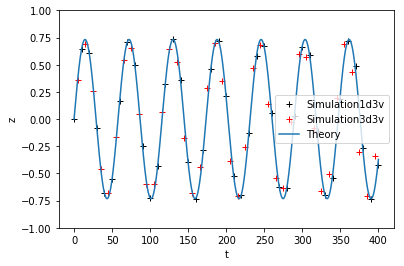

In [61]:
plt.plot(tn[::200],particles1d3v[::200,0,0],'k+',label = 'Simulation1d3v')
plt.plot(tn[100::200],particles3d3v[100::200,0,2],'r+',label = 'Simulation3d3v')
plt.plot(tn,zana(tn),label = 'Theory')
plt.xlabel('t')
plt.ylabel('z')
plt.ylim((-1,1))
plt.legend()